In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
import os
import numpy as np1
import pandas as pd

import mplhep as hep
plt.style.use(hep.style.CMS)

In [64]:
input_folder = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/reco_comparison/supercluster_regression/electrons"
output_folder = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/RecoPlots/RecoComparison_regression_UL18_v8_SCregression/tests"
os.makedirs(output_folder, exist_ok=True)


In [3]:
reco = "DeepSC_AlgoA"
df_1 = pd.HDFStore(f"{input_folder}/ele_UL18_123X_Mustache_v8_object.h5py", "r")["df"]
df_2 = pd.HDFStore(f"{input_folder}/ele_UL18_123X_{reco}_v8_object.h5py", "r")["df"]
df_1.rename(columns={"output_object.csv":"calomatched"}, inplace=True)
df_2.rename(columns={"output_object.csv":"calomatched"}, inplace=True)
df_1.rename(columns={"ncsl_tot":"ncls_tot"}, inplace=True)
df_2.rename(columns={"ncsl_tot":"ncls_tot"}, inplace=True)
df_1 = df_1.iloc[:-1]
df_2 = df_2.iloc[:-1]

df_1["Eraw_ov_Esim"] = df_1.en_sc_raw / df_1.calo_en_sim
df_1["Ecorr_ov_Esim"] = df_1.en_sc_calib / df_1.calo_en_sim
df_2["Eraw_ov_Esim"] = df_2.en_sc_raw / df_2.calo_en_sim
df_2["Ecorr_ov_Esim"] = df_2.en_sc_calib / df_2.calo_en_sim

df_1["Eraw_ov_EGen"] = df_1.en_sc_raw / df_1.genpart_en
df_1["Ecorr_ov_EGen"] = df_1.en_sc_calib / df_1.genpart_en
df_2["Eraw_ov_EGen"] = df_2.en_sc_raw / df_2.genpart_en
df_2["Ecorr_ov_EGen"] = df_2.en_sc_calib / df_2.genpart_en

df_1.rename(columns={"sc_index": "old_index"}, inplace=True)
df_2.rename(columns={"sc_index": "new_index"}, inplace=True)


df_join = df_1.merge(df_2, on=["runId","eventId","caloindex"], suffixes=["_old", "_new"],indicator=True)

## Resolution

In [52]:
def bin_analysis_extquantiles(col):
    def f(df):
        m = df[col].mean()
        A = (df[col].quantile(0.84) - df[col].quantile(0.16))/2
        B = (df[col].quantile(0.975) - df[col].quantile(0.025))/2
        return pd.Series({
            "m": m,
            "w68": A,
            "w95": B,
            "N": df[col].count()
        })
    return f

def bin_analysis_details(col):
    def f(df):
        m = df[col].mean()
        qu = df[col].quantile(0.84)
        qd = df[col].quantile(0.16)
        A = (qu - qd)/2
        quu = df[col].quantile(0.975)
        qdd = df[col].quantile(0.025)
        B = (quu- qdd )/2
        return pd.Series({
            "m": m,
            "w68": A,
            "w95": B,
            "w68_u": qu,
            "w68_d": qd,
            "w95_u" : quu,
            "w95_d" : qdd,
            "N": df[col].count()
        })
    return f


def get_quantiles(df):
    return df.quantile(0.025), df.quantile(0.16), df.quantile(0.5), df.quantile(0.84), df.quantile(0.975)


def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

from numba import jit

@jit(nopython=True)
def get_central_smallest_interval(df, xrange, nbins, Ntrial=10000, perc=0.68):
    H = np.histogram(df, bins=nbins, range=xrange)
    xmax = H[1][np.argmax(H[0])]
    deltax = (xrange[1]-xrange[0])/(2*Ntrial)
    
    N = df.size
    xd = xmax-deltax
    xu = xmax+deltax
    for i in range(Ntrial):
        q = np.sum((df>xd) &(df<xu))/ N
        if q>=perc: 
            break
        xd = xd-deltax
        xu = xu+deltax
    return xmax, xd, xu

def bin_analysis_central_smallest(col, xrange=(0.6, 1.2), nbins=200, Ntrial =10000):
    def f(df):
        data = df[col]
        xmax, qd, qu = get_central_smallest_interval(data.values, xrange=xrange, nbins=nbins, Ntrial =Ntrial )
        return pd.Series({
            "m": xmax,
            "w68": (qu-qd)/2,
            "w68_u": qu,
            "w68_d": qd,
            "N": df[col].count()
        })
    return f

## Dynamic fit function

The best fit range is extracted by first looking for the maximum and then getting the 95% central interval around it. 

In [5]:
from numba import jit 

@jit
def cruijff(x, A, m, sigmaL,sigmaR, alphaL, alphaR):
    dx = (x-m)
    SL = np.full(x.shape, sigmaL)
    SR = np.full(x.shape, sigmaR)
    AL = np.full(x.shape, alphaL)
    AR = np.full(x.shape, alphaR)
    sigma = np.where(dx<0, SL,SR)
    alpha = np.where(dx<0, AL,AR)
    f = 2*sigma*sigma + alpha*dx*dx ;
    return A* np.exp(-dx*dx/f) 

from scipy.optimize import curve_fit

def fit_cruijff(data, bins, xrange):
    H= np.histogram(data,bins=bins, range=xrange)
    x = H[1][:-1]
    Y = H[0]
    # delete empty bins
    x = x[Y>0]
    Y =Y[Y>0]
    params, pcovs = curve_fit(cruijff, x, Y, p0=[np.max(Y), 1, 0.02, 0.02,  0.15,0.15], 
                              sigma=np.sqrt(Y),absolute_sigma=True)
    return params, pcovs
    
    
def bin_analysis_cruijff(col, nbins=300, prange=0.95):
    def f(df):
        data = df[col].values
        # use the mode looking function to get a meaninful interval centered around the maximum and no tails
        # we just need a rought center estimate
        mean, xd, xu = get_central_smallest_interval(data, xrange=(0.6,1.3), nbins=200, perc=prange)
        
        try:
            params, pcovs = fit_cruijff(data, bins=nbins, xrange=(xd, xu) )
            perr = np.sqrt(np.diag(pcovs))

            return pd.Series({
                "m": params[1],
                "sigmaL": params[2], 
                "sigmaR": params[3],
                "alphaL": params[4],
                "alphaR": params[5],
                "m_err": perr[1],
                "sigmaL_err": perr[2], 
                "sigmaR_err": perr[3],
                "alphaL_err": perr[4],
                "alphaR_err": perr[5],
                "A": params[0],
                "A_err": perr[0],
                "N": df[col].count(),
                "xmin": xd,
                "xmax": xu
            })
        except:
            print("Fit failed")
            return pd.Series({
                "m": mean,
                "sigmaL": -1, 
                "sigmaR": -1,
                "alphaL": -1,
                "alphaR": -1,
                "m_err": -1,
                "sigmaL_err": -1, 
                "sigmaR_err": -1,
                "alphaL_err": -1,
                "alphaR_err": -1,
                "A": -1,
                "A_err": -1,
                "N": df[col].count(),
                "xmin": xd,
                "xmax": xu
            })
    return f


### Generic plotting function

In [75]:
def do_plot(*, name, df, res_var, 
            bins1, bins2, binlabel1, binlabel2, binvar1, binvar2, binleg,
            xlabel, ylabel, general_label, ylabelratio,
            yvar, ylims1, ylims2, 
            bin_analysis="fit", exclude_bin=-1, 
            nbins_fit=250, prange=1, 
            fill_between=None,  output_folder=None):
    
    binLabel1 = binlabel1+"_bin"
    binLabel2 = binlabel2+"_bin"
    df[binLabel1] = pd.cut(df[binvar1].abs(), bins1, labels=list(range(len(bins1)-1)))
    df[binLabel2] = pd.cut(df[binvar2].abs(), bins2, labels=list(range(len(bins2)-1)))
    
    if bin_analysis == "fit":
        res = df.groupby([binLabel1,binLabel2]).apply(bin_analysis_cruijff(f"{res_var}_new", nbins=nbins_fit, prange=prange))
        res_must = df.groupby([binLabel1,binLabel2]).apply(bin_analysis_cruijff(f"{res_var}_old", nbins=nbins_fit, prange=prange))
    elif bin_analysis == "ext_quantile":
        res = df.groupby([binLabel1,binLabel2]).apply(bin_analysis_extquantiles(f"{res_var}_new"))
        res_must = df.groupby([binLabel1,binLabel2]).apply(bin_analysis_extquantiles(f"{res_var}_old"))
    elif bin_analysis == "central_quantile":
        res = df.groupby([binLabel1,binLabel2]).apply(bin_analysis_central_smallest(f"{res_var}_new"))
        res_must = df.groupby([binLabel1,binLabel2]).apply(bin_analysis_central_smallest(f"{res_var}_old"))
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    
    if yvar=="sigma_avg":
        res["sigma_avg"] = (res.sigmaL + res.sigmaR)/2
        res_must["sigma_avg"] = (res_must.sigmaL + res_must.sigmaR)/2
    
    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(bins1)-1):
        errx.append((bins1[i+1]- bins1[i])/2)
        x.append((bins1[i+1]+ bins1[i])/2)

    mustl = []
    deepl = []

    res.loc[res[binLabel2] == exclude_bin, [yvar]] = 0
    res_must.loc[res_must[binLabel2] == exclude_bin, [yvar]] = 0
    

    for iet, et in enumerate(bins2[:-1]):
        if iet == exclude_bin: continue
        l = axs[0].errorbar(x, res_must[res_must[binLabel2] == iet][yvar], xerr=errx, label=f"[{bins2[iet]}, {bins2[iet+1]}]", fmt = ".")
        mustl.append(l)

    i = 0
    for iet, et in enumerate(bins2[:-1]):
        if iet == exclude_bin: continue
        l = axs[0].errorbar(x, res[res[binLabel2]== iet][yvar],  xerr=errx ,label=f"[{bins2[iet]}, {bins2[iet+1]}]", 
                                c=mustl[i].lines[0].get_color(), marker="s", markerfacecolor='none', linestyle='none',elinewidth=0)
        i+=1
        deepl.append(l)

    if fill_between:
        axs[0].fill_between(fill_between, [ylims1[0]]*2,[ylims1[1]]*2, color="lightgray", alpha=0.5)
        axs[1].fill_between(fill_between, [ylims2[0]]*2,[ylims2[1]]*2, color="lightgray", alpha=0.5)


    for iet, et in enumerate(bins2[:-1]):
        if iet == exclude_bin: continue
        var = res[res[binLabel2]==iet][yvar] / res_must[res_must[binLabel2]==iet][yvar]
        axs[1].errorbar(x, var,xerr=errx,  fmt="o", linestyle='none', elinewidth=0)
        

    axs[0].set_ylabel(ylabel)
    axs[1].set_xlabel(xlabel)
    axs[0].set_ylim(*ylims1)
    axs[1].set_ylim(*ylims2)
    

    axs[1].set_ylabel(ylabelratio, fontsize=22)
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)

    l1= axs[0].legend(handles=mustl, title=binleg, title_fontsize=18, loc="upper left", fontsize=18)

    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.7, 1), fontsize=18)
    axs[0].add_artist(l1)


  
    axs[0].text(0.65, 0.6, general_label, transform=axs[0].transAxes, fontsize=20)

    axs[0].set_yscale("log")
    axs[0].grid(which="both",axis="y")
    axs[1].grid(which="both",axis="y")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])
    
    if (output_folder):
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + f"/resolution_{name}_{yvar}_ratio.png")
        fig.savefig(output_folder + f"/resolution_{name}_{yvar}_ratio.pdf")
        fig.savefig(output_folder + f"/resolution_{name}_{yvar}_ratio.svg")
    
    return res, res_must

Fit failed


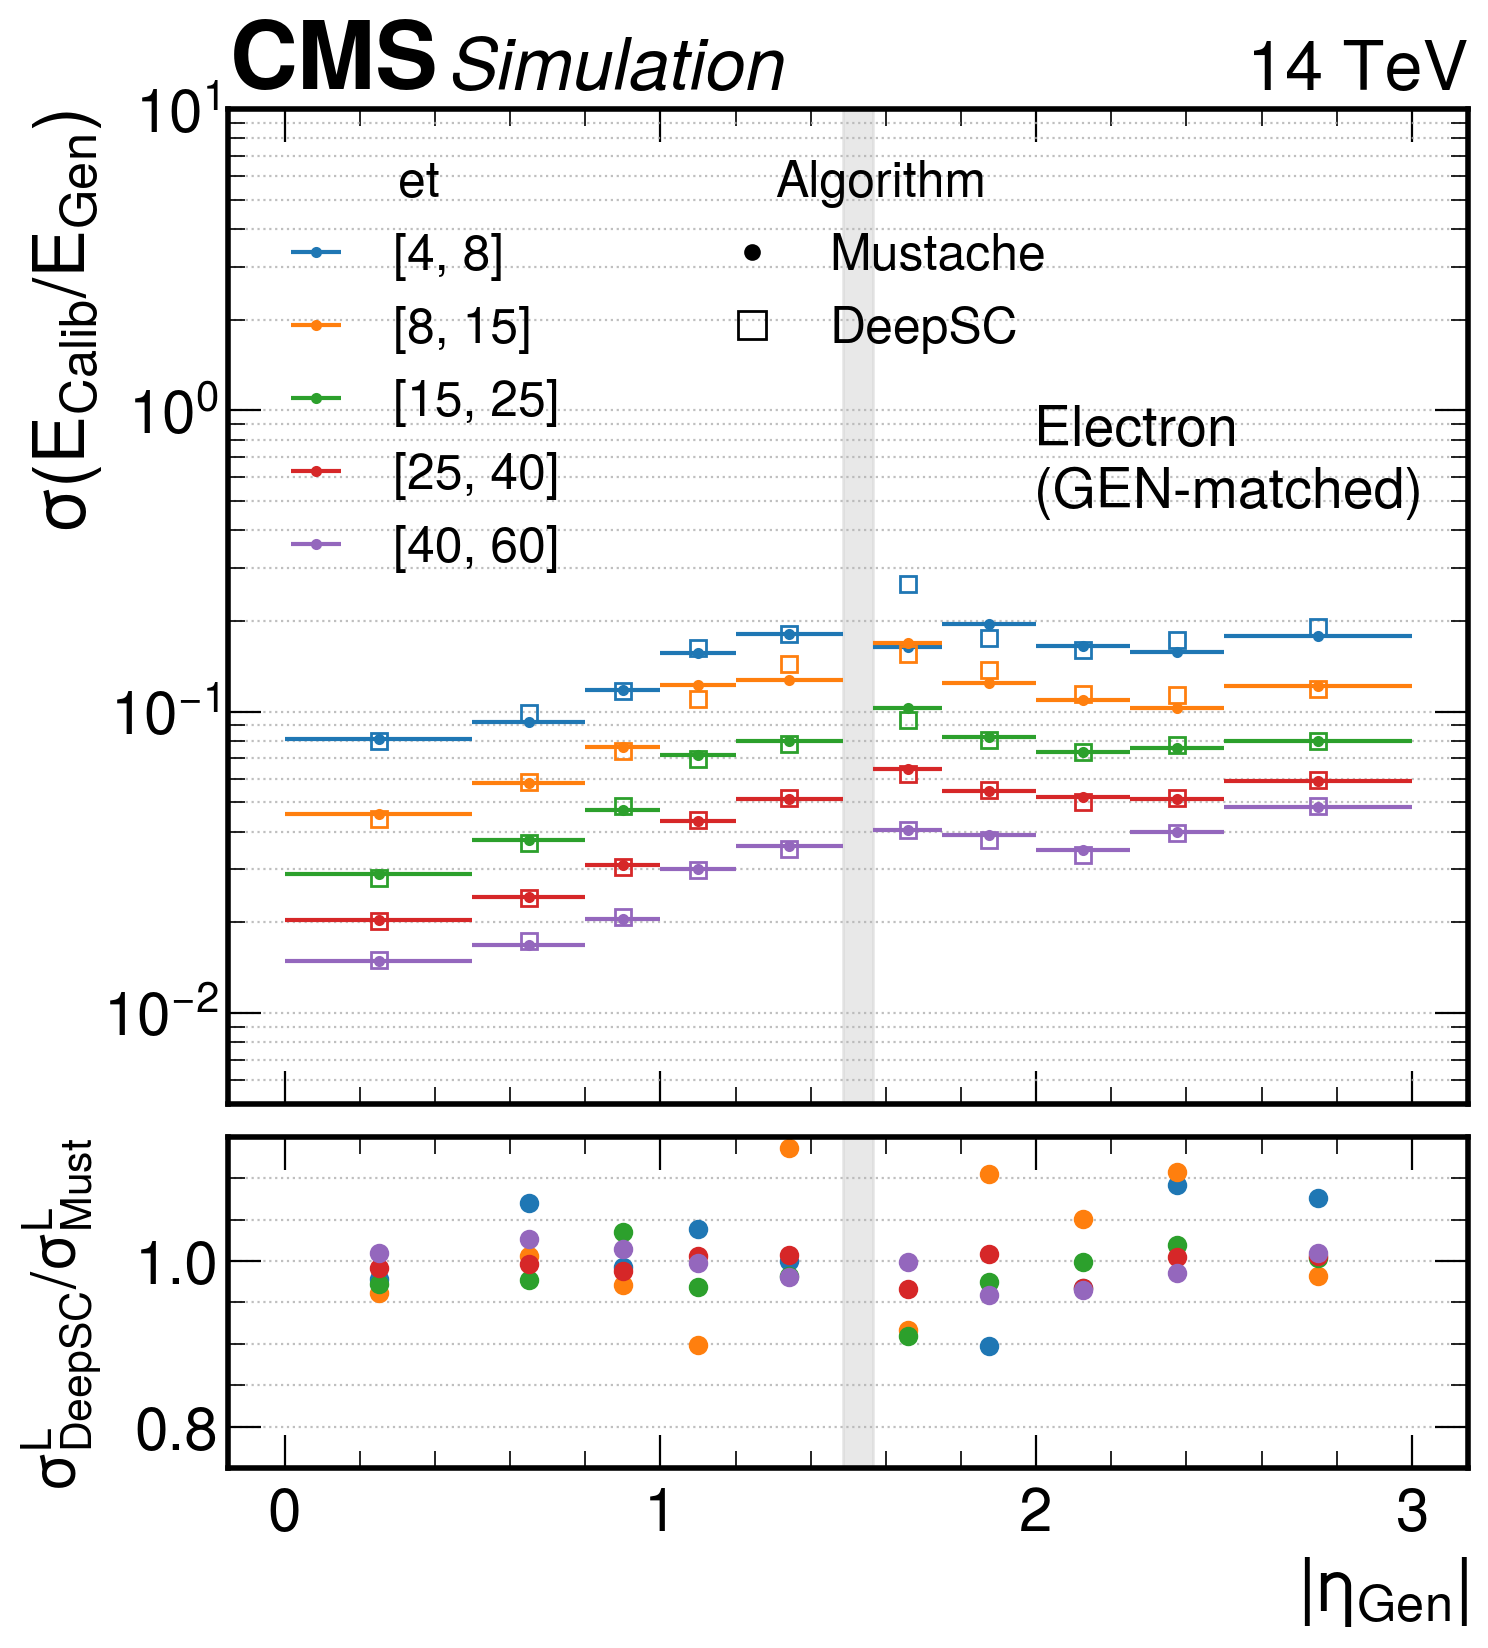

In [47]:
res_d, res_m = do_plot(name="ele_gen_matched_corr",
        df=df_join, 
        res_var="Ecorr_ov_EGen", 
        bins1=[0, 0.5,0.8,1.0,1.2, 1.485, 1.566, 1.75, 2.,2.25,2.5,3],
        bins2=[4,8,15,25, 40,60], 
        binlabel1="eta",
        binlabel2="et",
        binleg="$E_T^{Gen}$", 
        binvar1="seed_eta_new", 
        binvar2="calo_et_gen_new", 
        nbins_fit=250, 
        prange=0.98, 
        exclude_bin=5, 
        general_label="Electron \n(GEN-matched)", 
        xlabel="$|\eta_{Gen}|$", 
        ylabel="$\sigma (E_{Calib}/E_{Gen})$",
        ylabelratio="$\sigma_{DeepSC}^L/\sigma_{Must}^L$", 
        yvar="sigmaL",
        ylims1=(5e-3,1e1),
        ylims2=(0.75, 1.15),
        fill_between=[1.485, 1.566],
        output_folder=None)

Fit failed


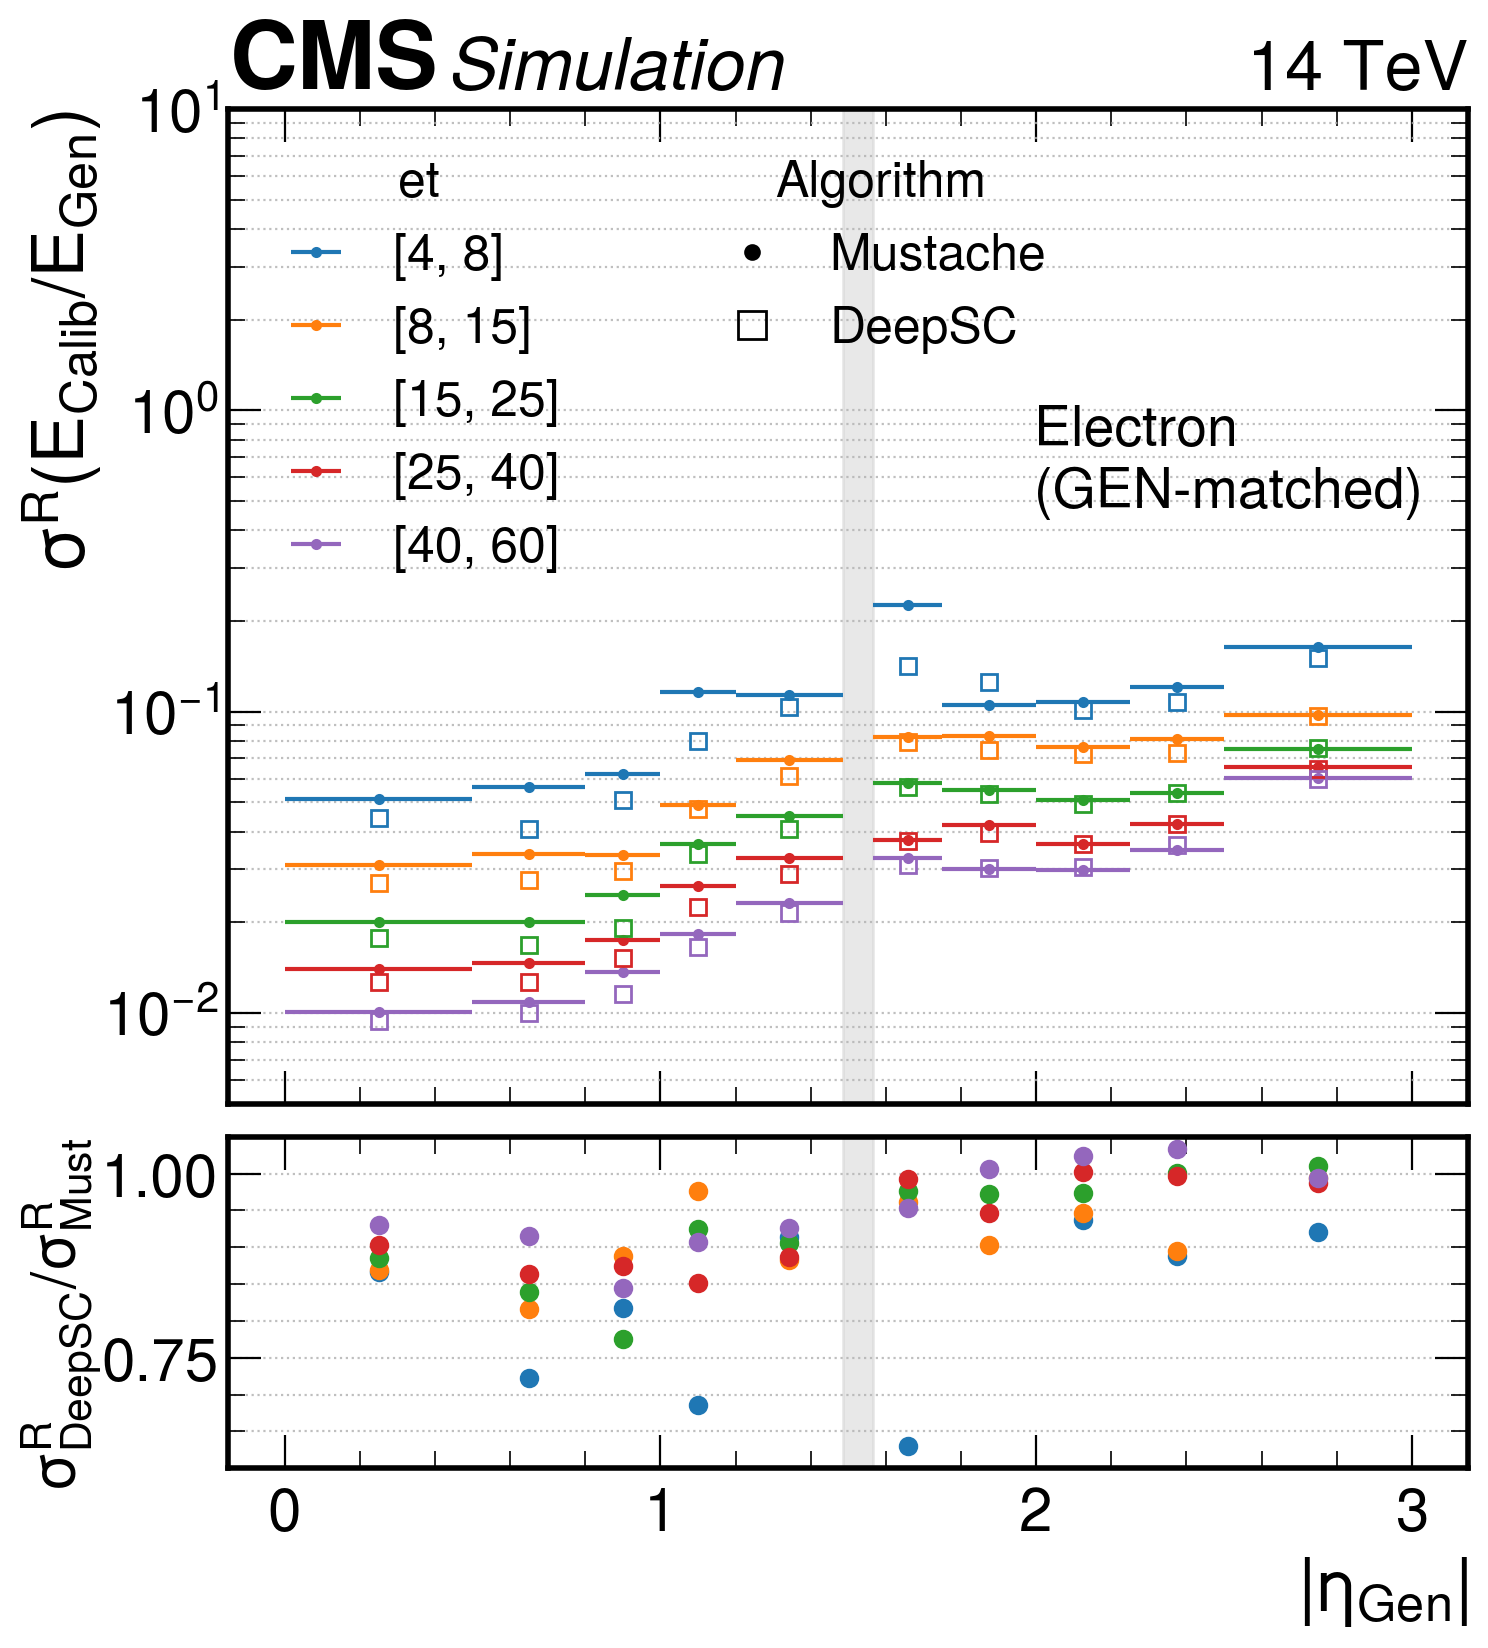

In [50]:
res_d, res_m = do_plot(name="ele_gen_matched_corr",
        df=df_join, 
        res_var="Ecorr_ov_EGen", 
        bins1=[0, 0.5,0.8,1.0,1.2, 1.485, 1.566, 1.75, 2.,2.25,2.5,3],
        bins2=[4,8,15,25, 40,60], 
        binlabel1="eta",
        binlabel2="et",
        binleg="$E_T^{Gen}$", 
        binvar1="seed_eta_new", 
        binvar2="calo_et_gen_new", 
        nbins_fit=250, 
        prange=0.98, 
        exclude_bin=5, 
        general_label="Electron \n(GEN-matched)", 
        xlabel="$|\eta_{Gen}|$", 
        ylabel="$\sigma^R (E_{Calib}/E_{Gen})$",
        ylabelratio="$\sigma_{DeepSC}^R/\sigma_{Must}^R$", 
        yvar="sigmaR",
        ylims1=(5e-3,1e1),
        ylims2=(0.6, 1.05),
        fill_between=[1.485, 1.566],
        output_folder=None)

Fit failed


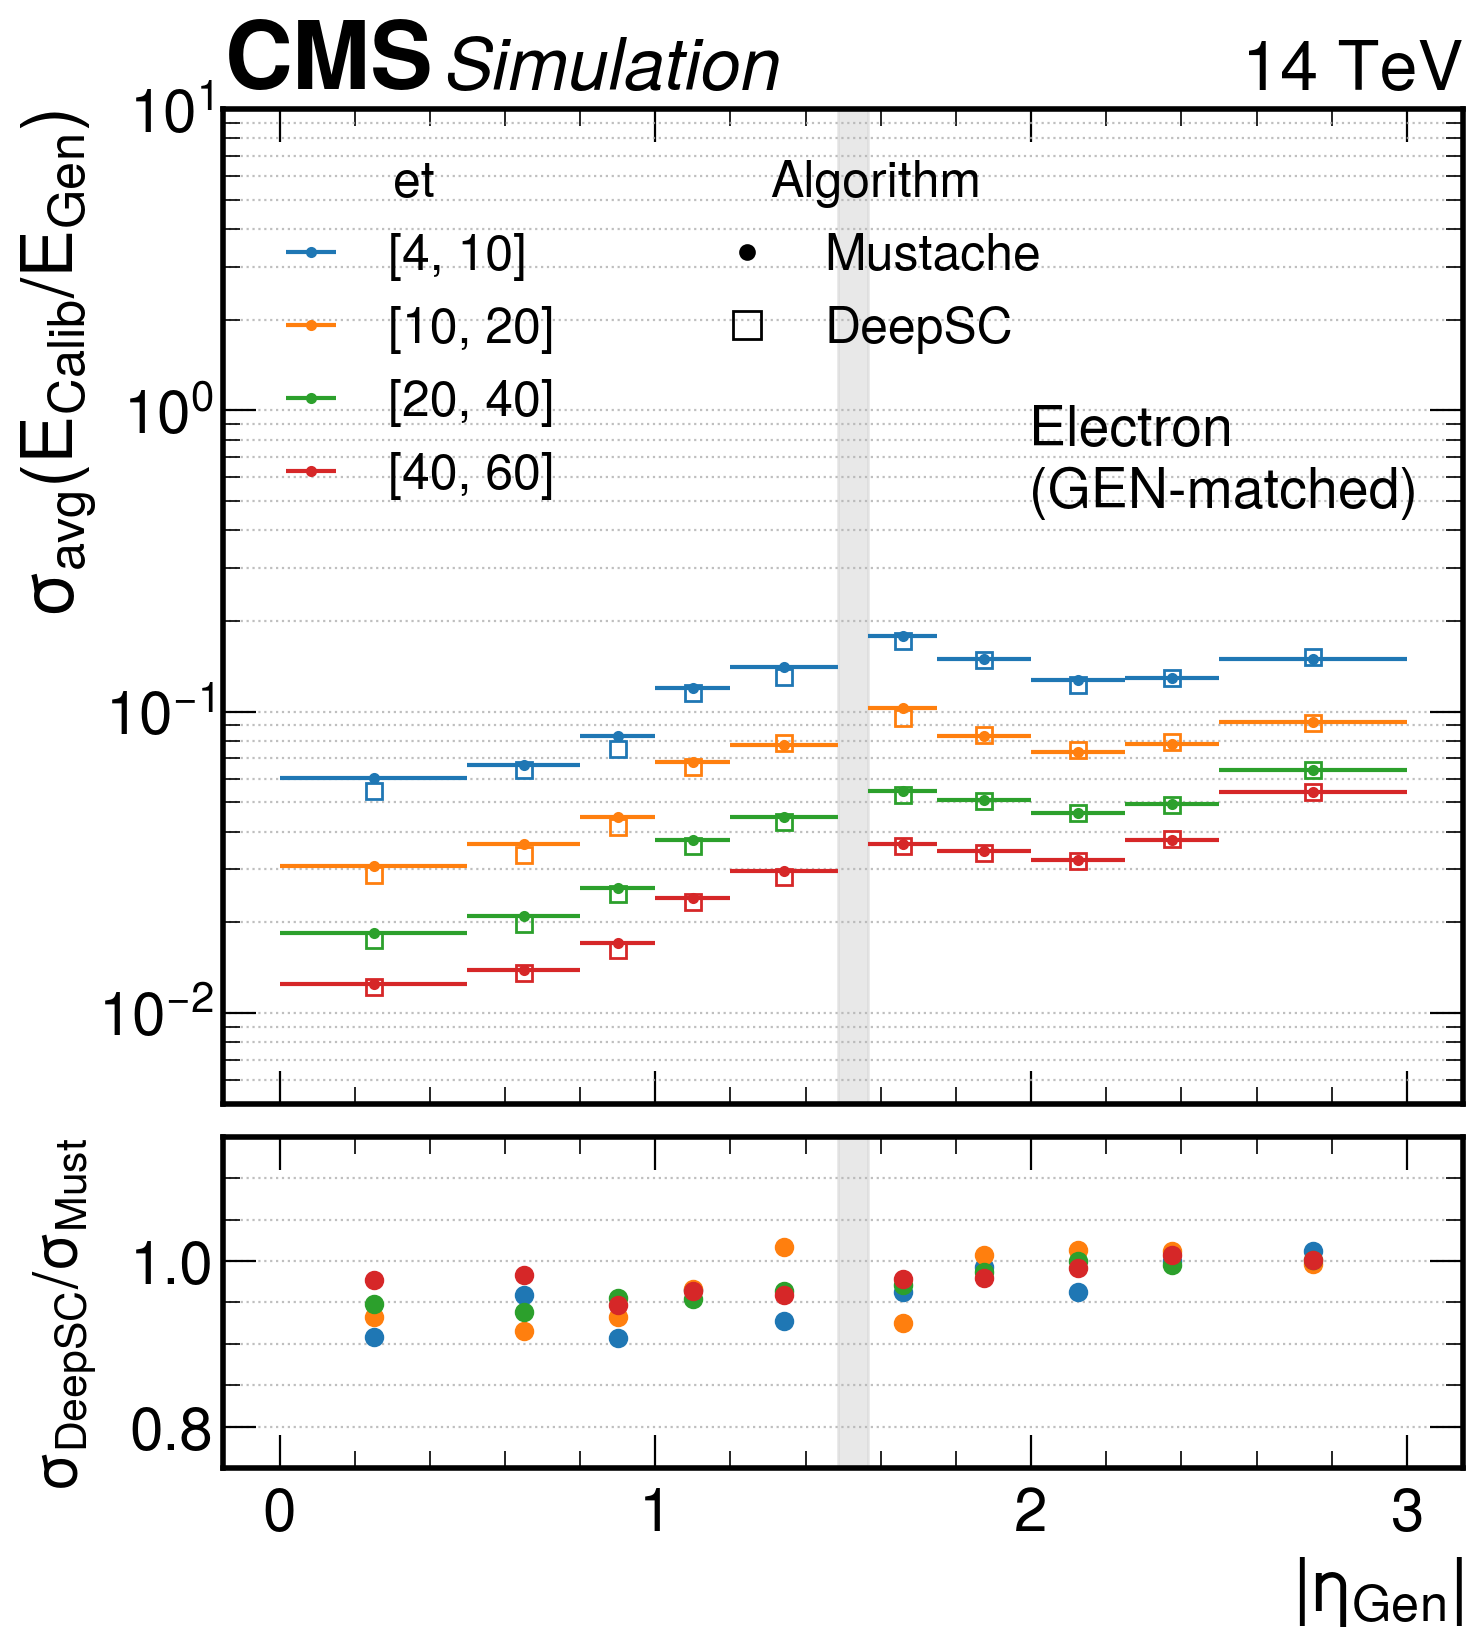

In [45]:
res_d, res_m = do_plot(name="ele_gen_matched_corr",
        df=df_join, 
        res_var="Ecorr_ov_EGen", 
        bins1=[0, 0.5,0.8,1.0,1.2, 1.485, 1.566, 1.75, 2.,2.25,2.5,3],
        bins2=[4,10,20,40,60], 
        binlabel1="eta",
        binlabel2="et",
        binleg="$E_T^{Gen}$", 
        binvar1="seed_eta_new", 
        binvar2="calo_et_gen_new", 
        nbins_fit=250, 
        prange=0.98, 
        exclude_bin=5, 
        general_label="Electron \n(GEN-matched)", 
        xlabel="$|\eta_{Gen}|$", 
        ylabel="$\sigma_{avg}(E_{Calib}/E_{Gen})$",
        ylabelratio="$\sigma_{DeepSC}/\sigma_{Must}$", 
        yvar="sigma_avg",
        ylims1=(5e-3,1e1),
        ylims2=(0.75, 1.15),
        fill_between=[1.485, 1.566],
        output_folder=None)

Fit failed
Fit failed


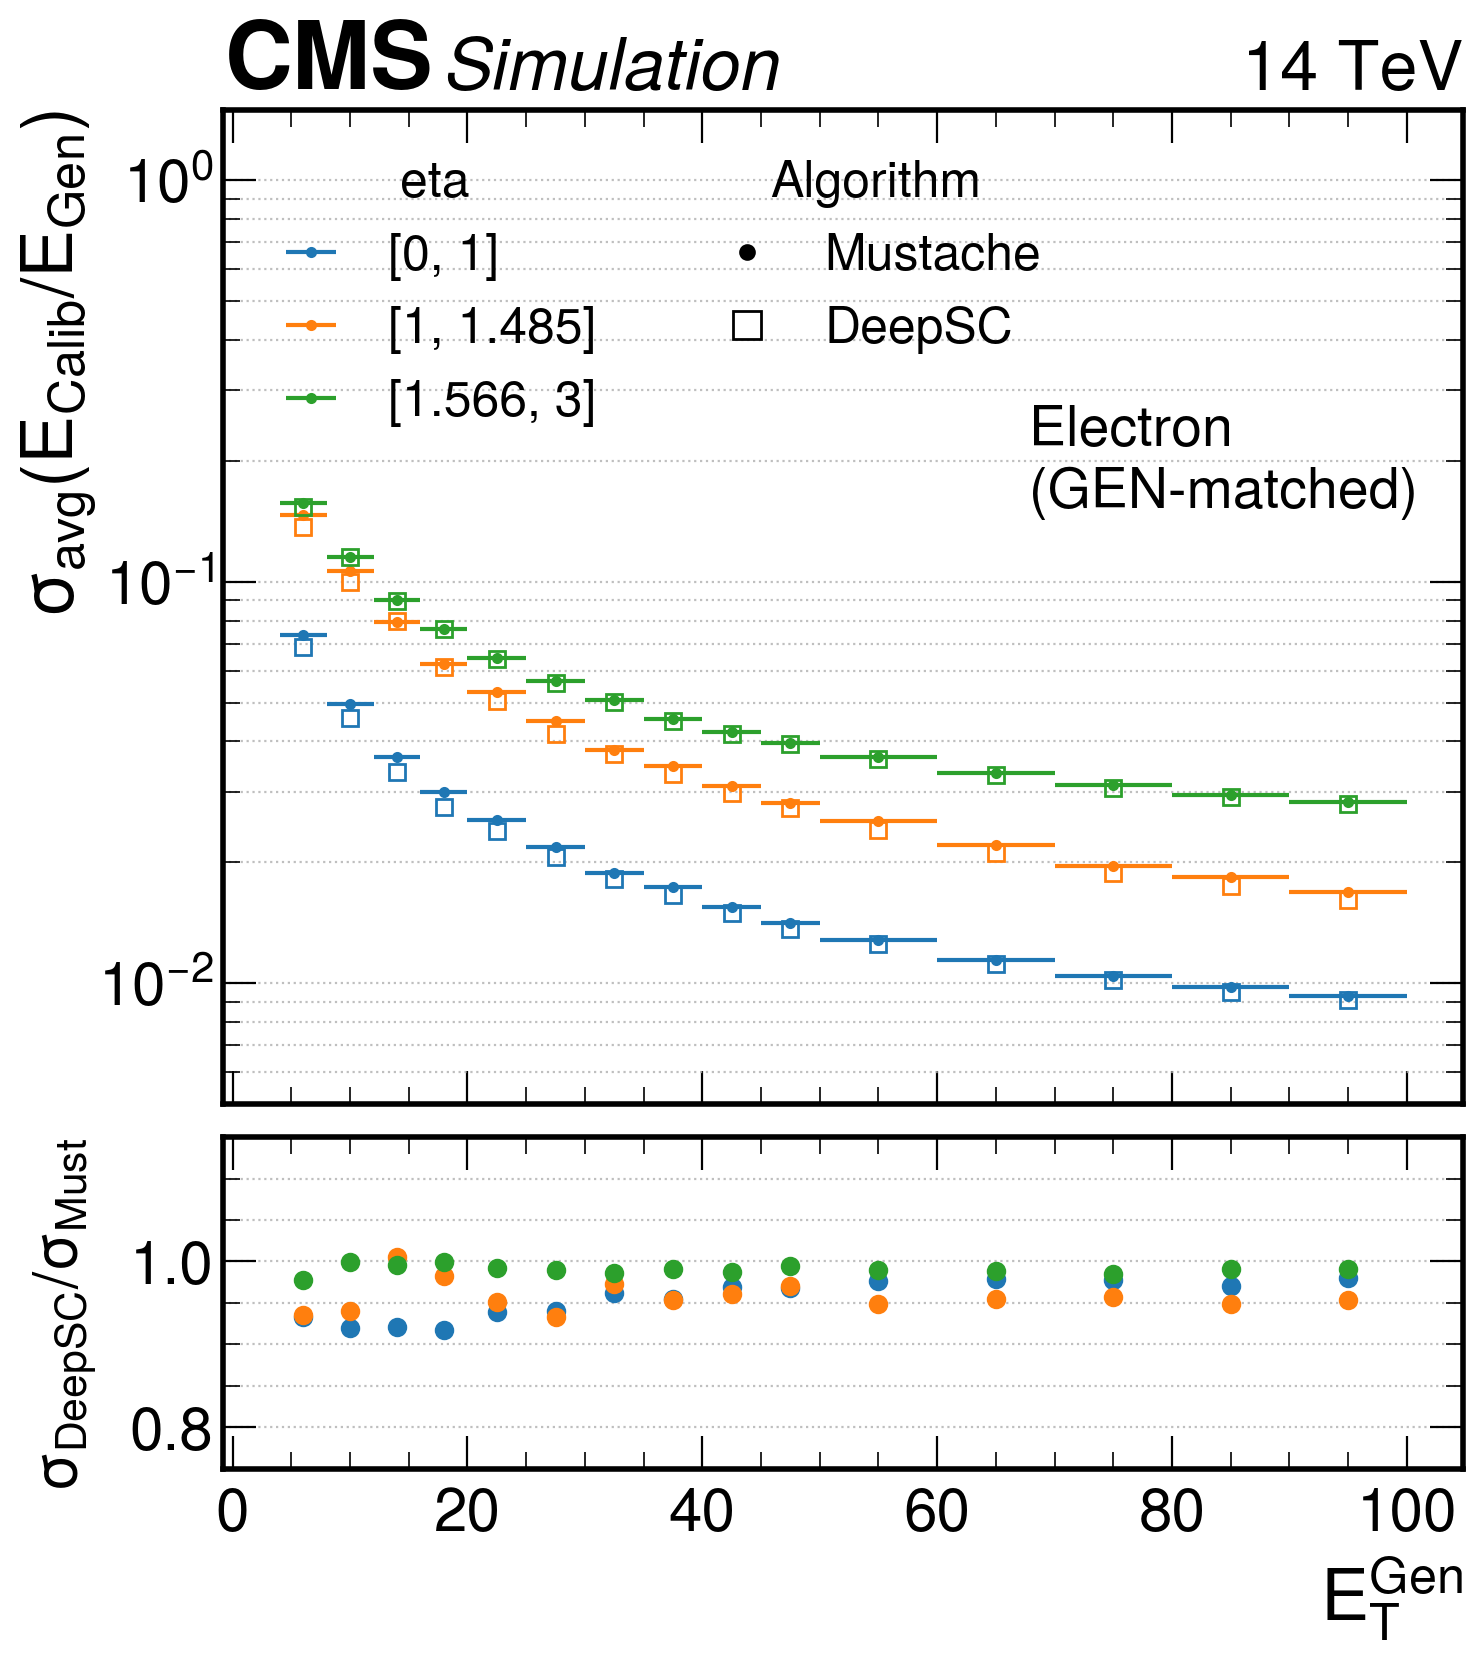

In [59]:
res_d, res_m = do_plot(name="ele_gen_matched_corr_byEt",
        df=df_join, 
        res_var="Ecorr_ov_EGen", 
        bins1=[4, 8, 12,16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100],
        bins2=[0, 1, 1.485, 1.566, 3], 
        exclude_bin=2, 
        binlabel1="et", 
        binlabel2="eta", 
        binleg= "$\eta_{Gen}$",
        binvar1="calo_et_gen_new", 
        binvar2="seed_eta_new", 
        nbins_fit=250, 
        prange=0.98, 
        general_label="Electron \n(GEN-matched)", 
        xlabel="$E_T^{Gen}$", 
        ylabel="$\sigma_{avg} (E_{Calib}/E_{Gen})$",
        ylabelratio="$\sigma_{DeepSC}/\sigma_{Must}$", 
        yvar="sigma_avg",
        ylims1=(5e-3,1.5),
        ylims2=(0.75, 1.15),
        output_folder=None)

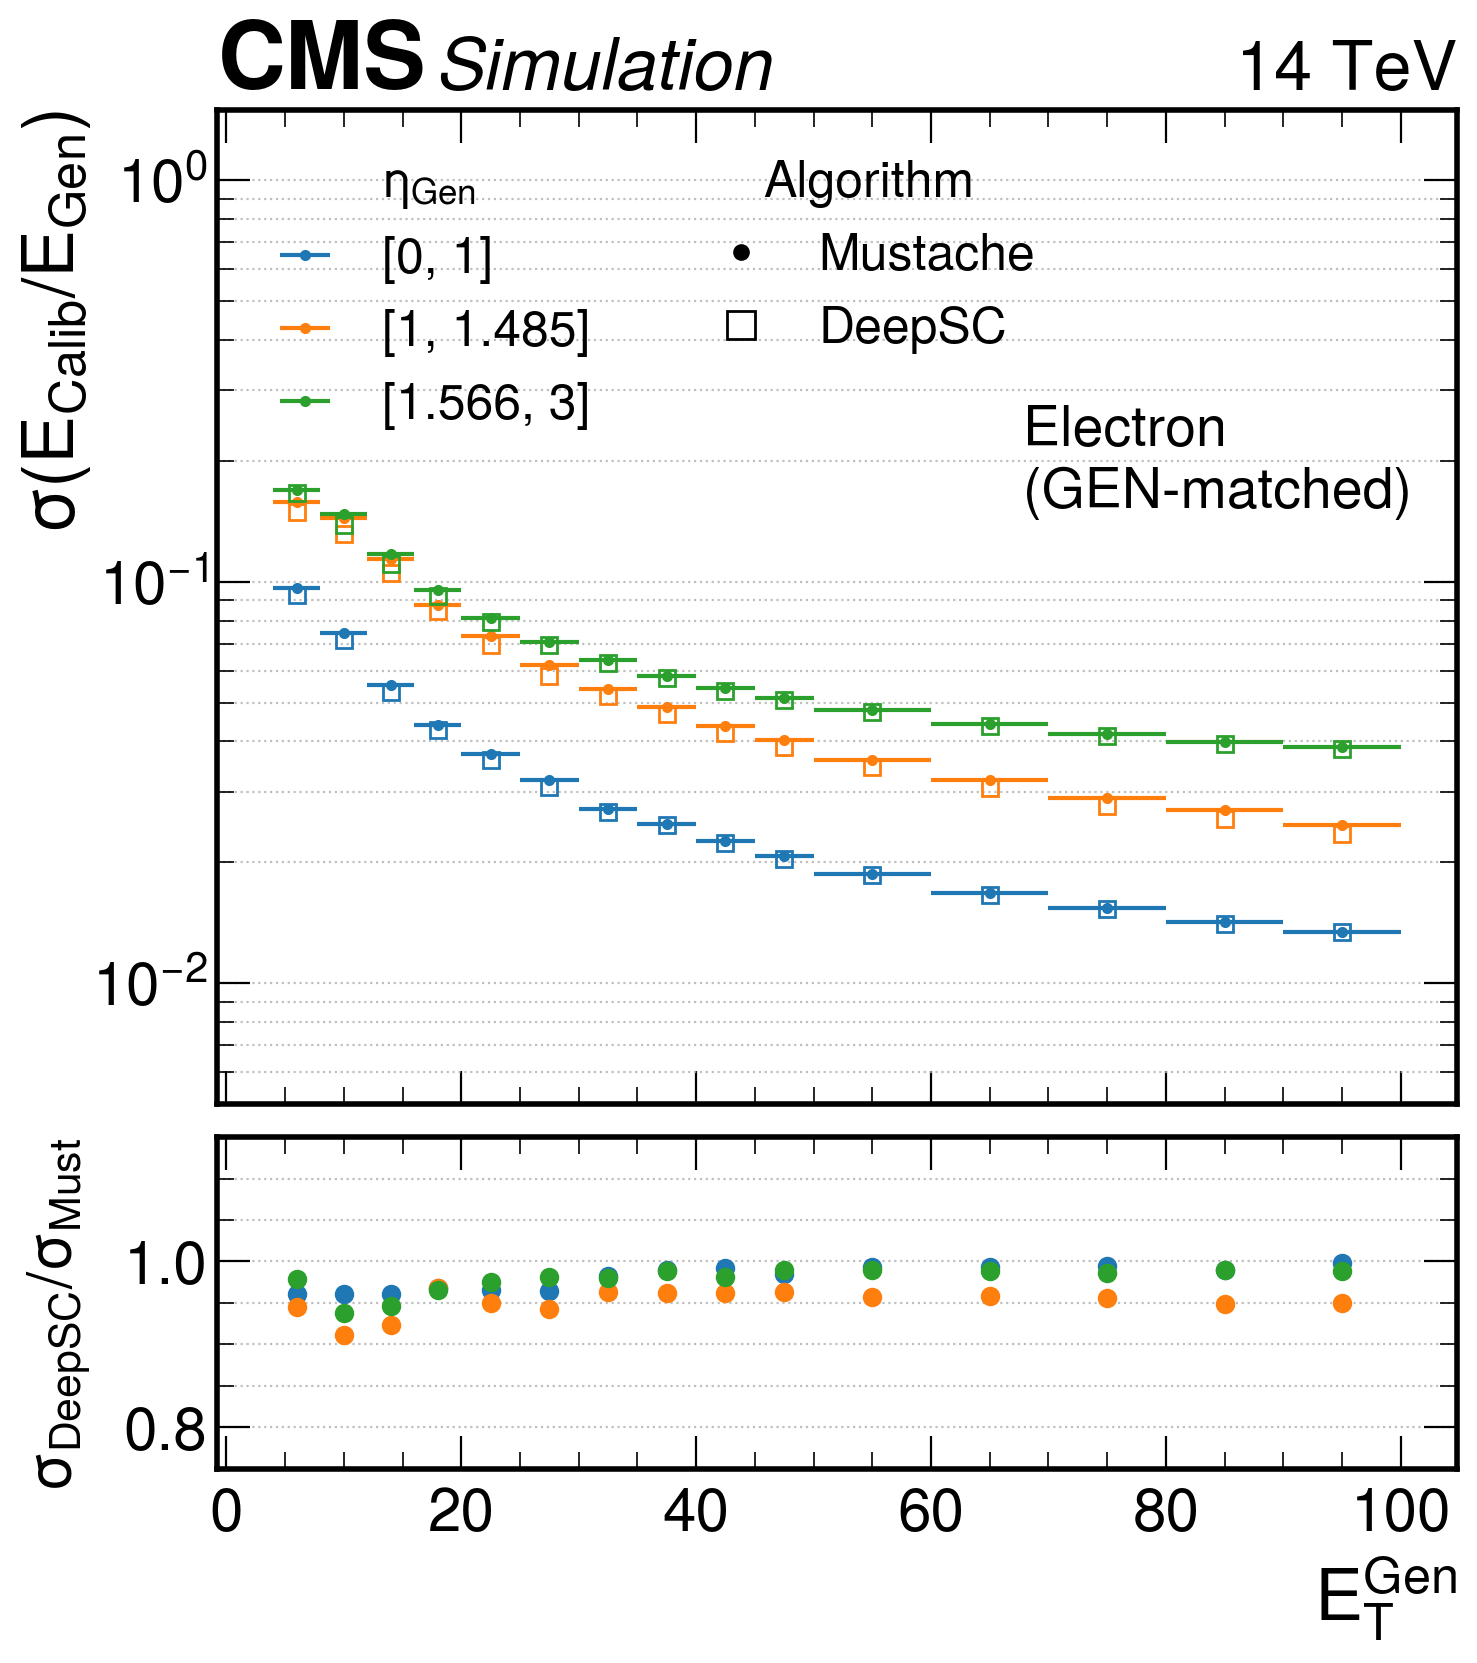

In [63]:
res_d, res_m = do_plot(name="ele_gen_matched_corr_byEt",
        df=df_join, 
        res_var="Ecorr_ov_EGen", 
        bins1=[4, 8, 12,16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100],
        bins2=[0, 1, 1.485, 1.566, 3], 
        exclude_bin=2, 
        binlabel1="et", 
        binlabel2="eta", 
        binleg= "$\eta_{Gen}$",
        binvar1="calo_et_gen_new", 
        binvar2="seed_eta_new", 
        nbins_fit=250, 
        prange=0.98, 
        general_label="Electron \n(GEN-matched)", 
        xlabel="$E_T^{Gen}$", 
        ylabel="$\sigma (E_{Calib}/E_{Gen})$",
        ylabelratio="$\sigma_{DeepSC}/\sigma_{Must}$", 
        yvar="w68",
        bin_analysis="ext_quantile",      
        ylims1=(5e-3,1.5),
        ylims2=(0.75, 1.15),
        output_folder=None)

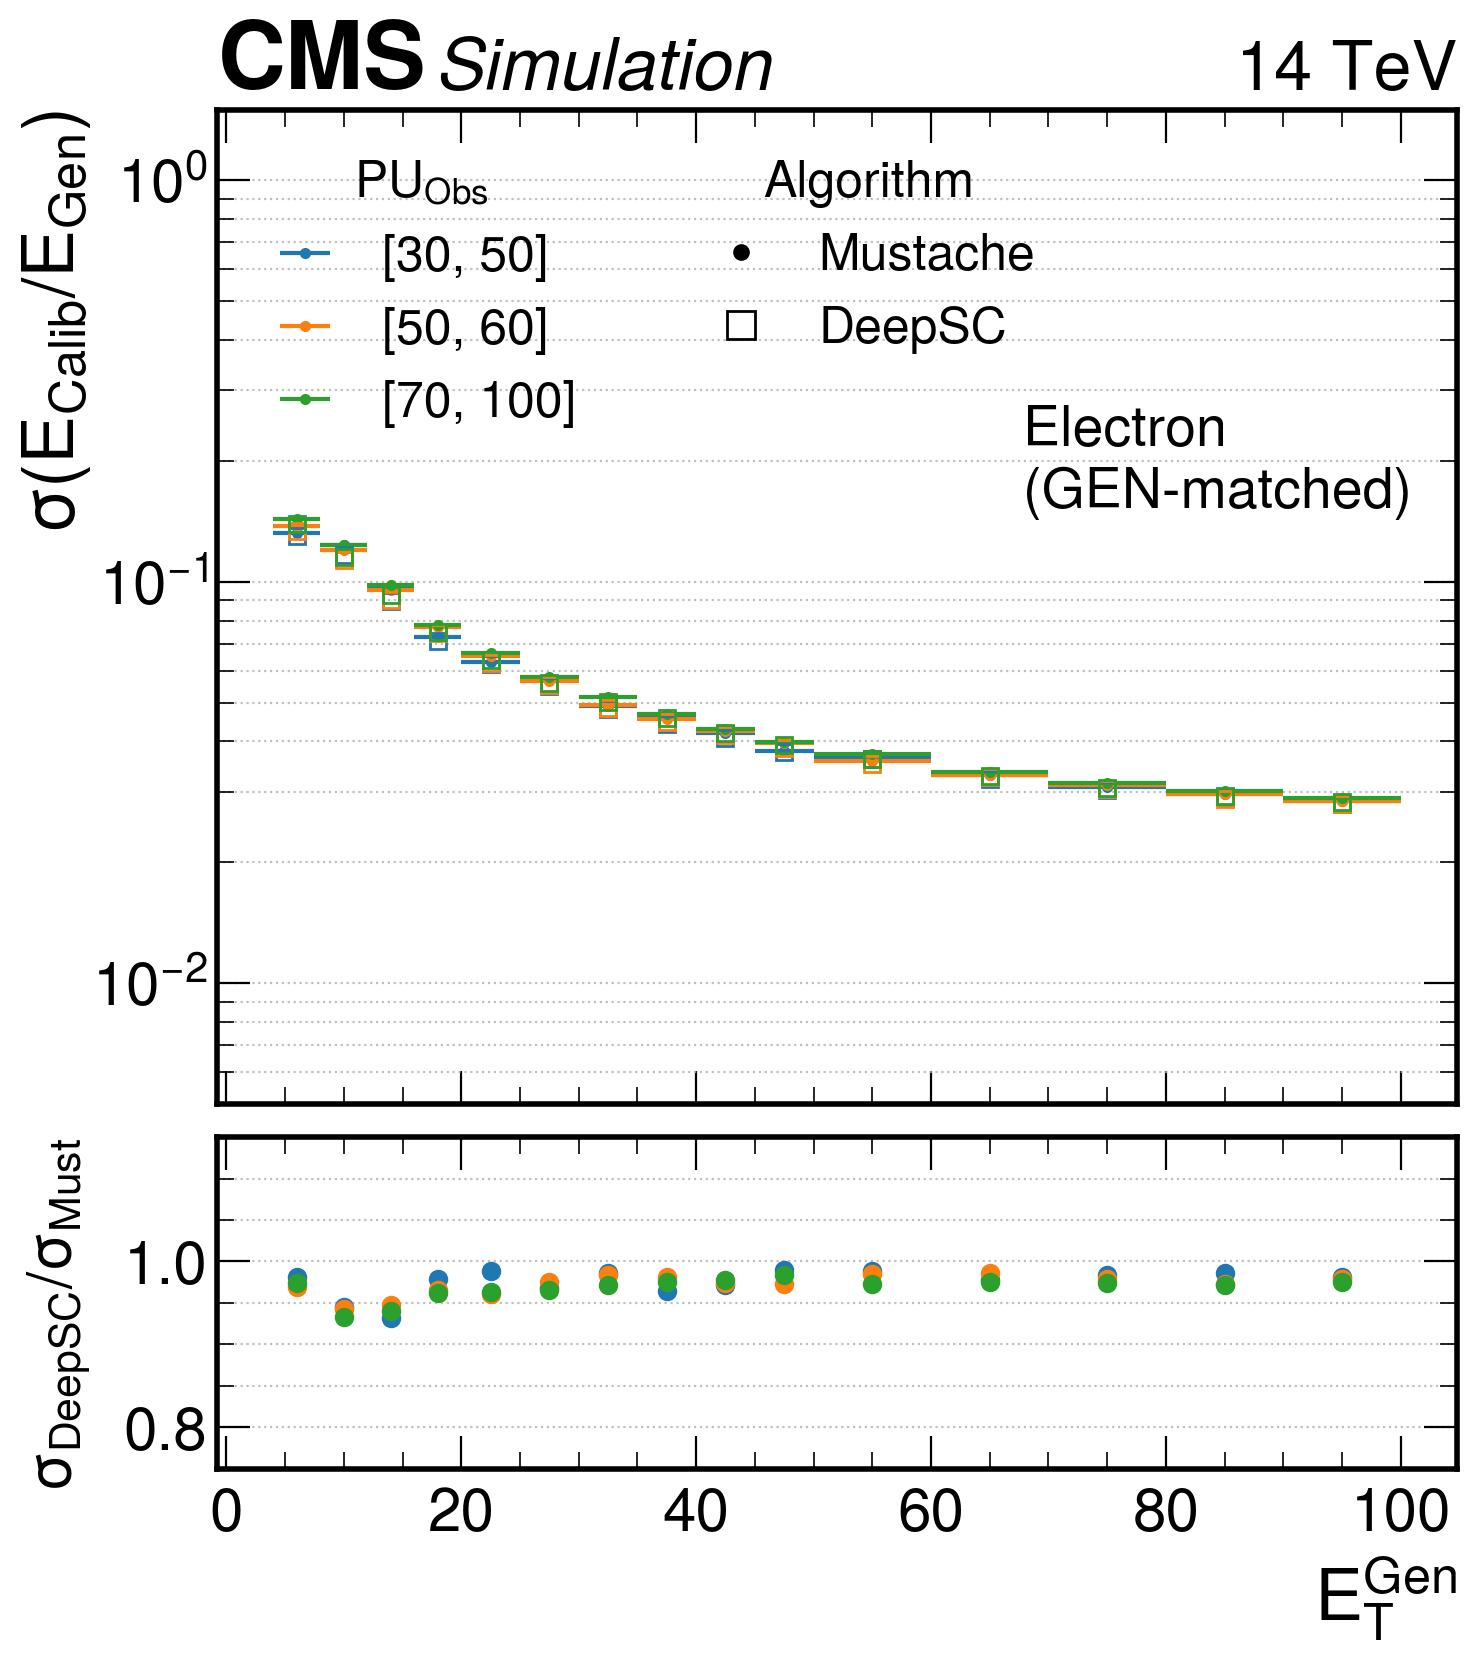

In [72]:
res_d, res_m = do_plot(name="ele_gen_matched_corr_byPU",
        df=df_join, 
        res_var="Ecorr_ov_EGen", 
        bins1=[4, 8, 12,16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100],
        bins2=[30,50,60,70,100], 
        exclude_bin=2, 
        binlabel1="et", 
        binlabel2="pu", 
        binleg= "$PU_{Obs}$",
        binvar1="calo_et_gen_new", 
        binvar2="obsPU_new", 
        general_label="Electron \n(GEN-matched)", 
        xlabel="$E_T^{Gen}$", 
        ylabel="$\sigma (E_{Calib}/E_{Gen})$",
        ylabelratio="$\sigma_{DeepSC}/\sigma_{Must}$", 
        yvar="w68",
        bin_analysis="ext_quantile",      
        ylims1=(5e-3,1.5),
        ylims2=(0.75, 1.15),
        output_folder=output_folder)

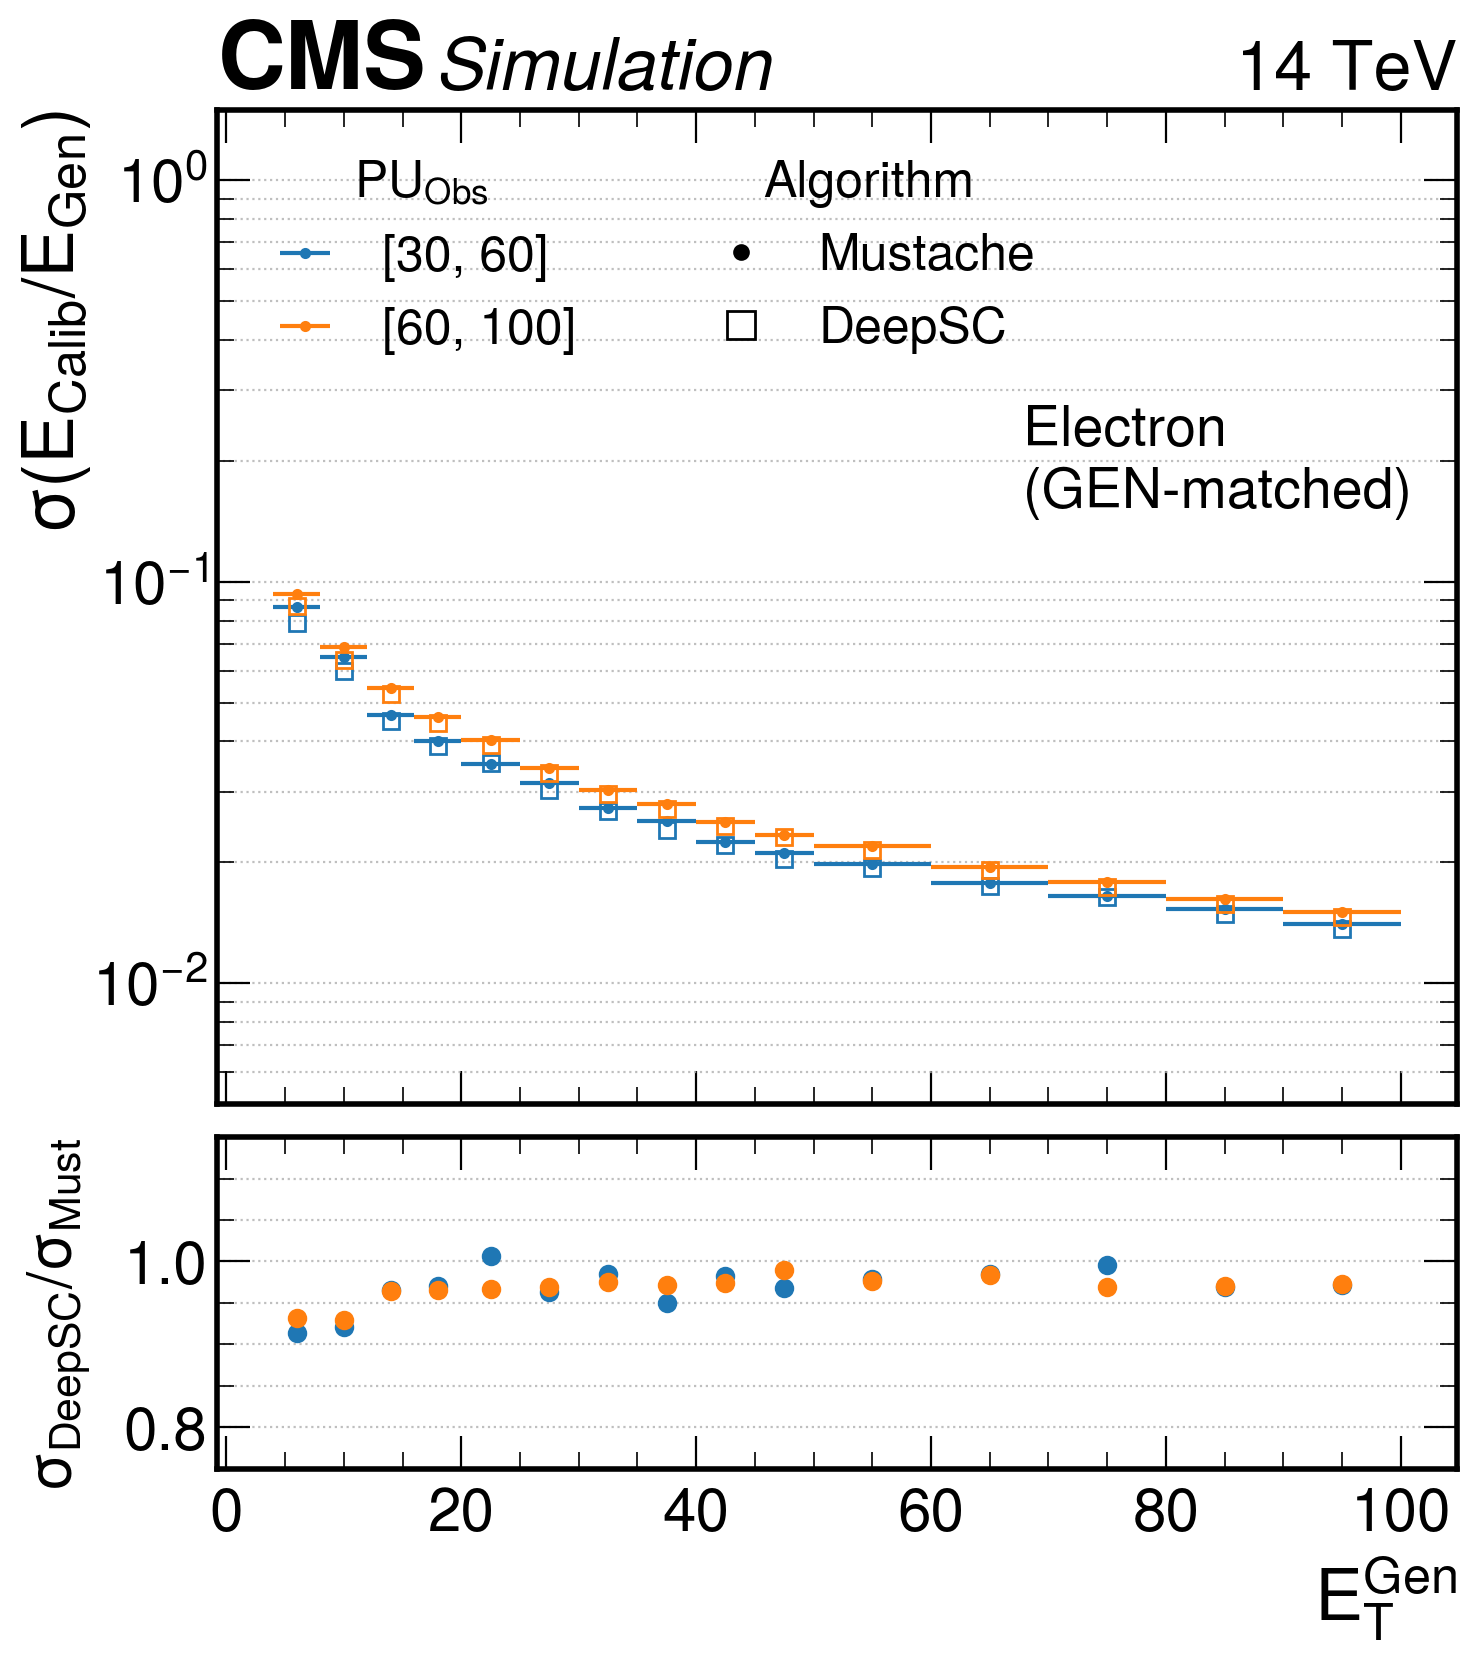

In [74]:
res_d, res_m = do_plot(name="ele_gen_matched_corr_byPU",
        df=df_join, 
        res_var="Ecorr_ov_EGen", 
        bins1=[4, 8, 12,16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100],
        bins2=[30,60,100], 
        exclude_bin=2, 
        binlabel1="et", 
        binlabel2="pu", 
        binleg= "$PU_{Obs}$",
        binvar1="calo_et_gen_new", 
        binvar2="obsPU_new", 
        general_label="Electron \n(GEN-matched)", 
        xlabel="$E_T^{Gen}$", 
        ylabel="$\sigma (E_{Calib}/E_{Gen})$",
        ylabelratio="$\sigma_{DeepSC}/\sigma_{Must}$", 
        yvar="sigmaR",
        bin_analysis="fit",      
        ylims1=(5e-3,1.5),
        ylims2=(0.75, 1.15),
        output_folder=output_folder)

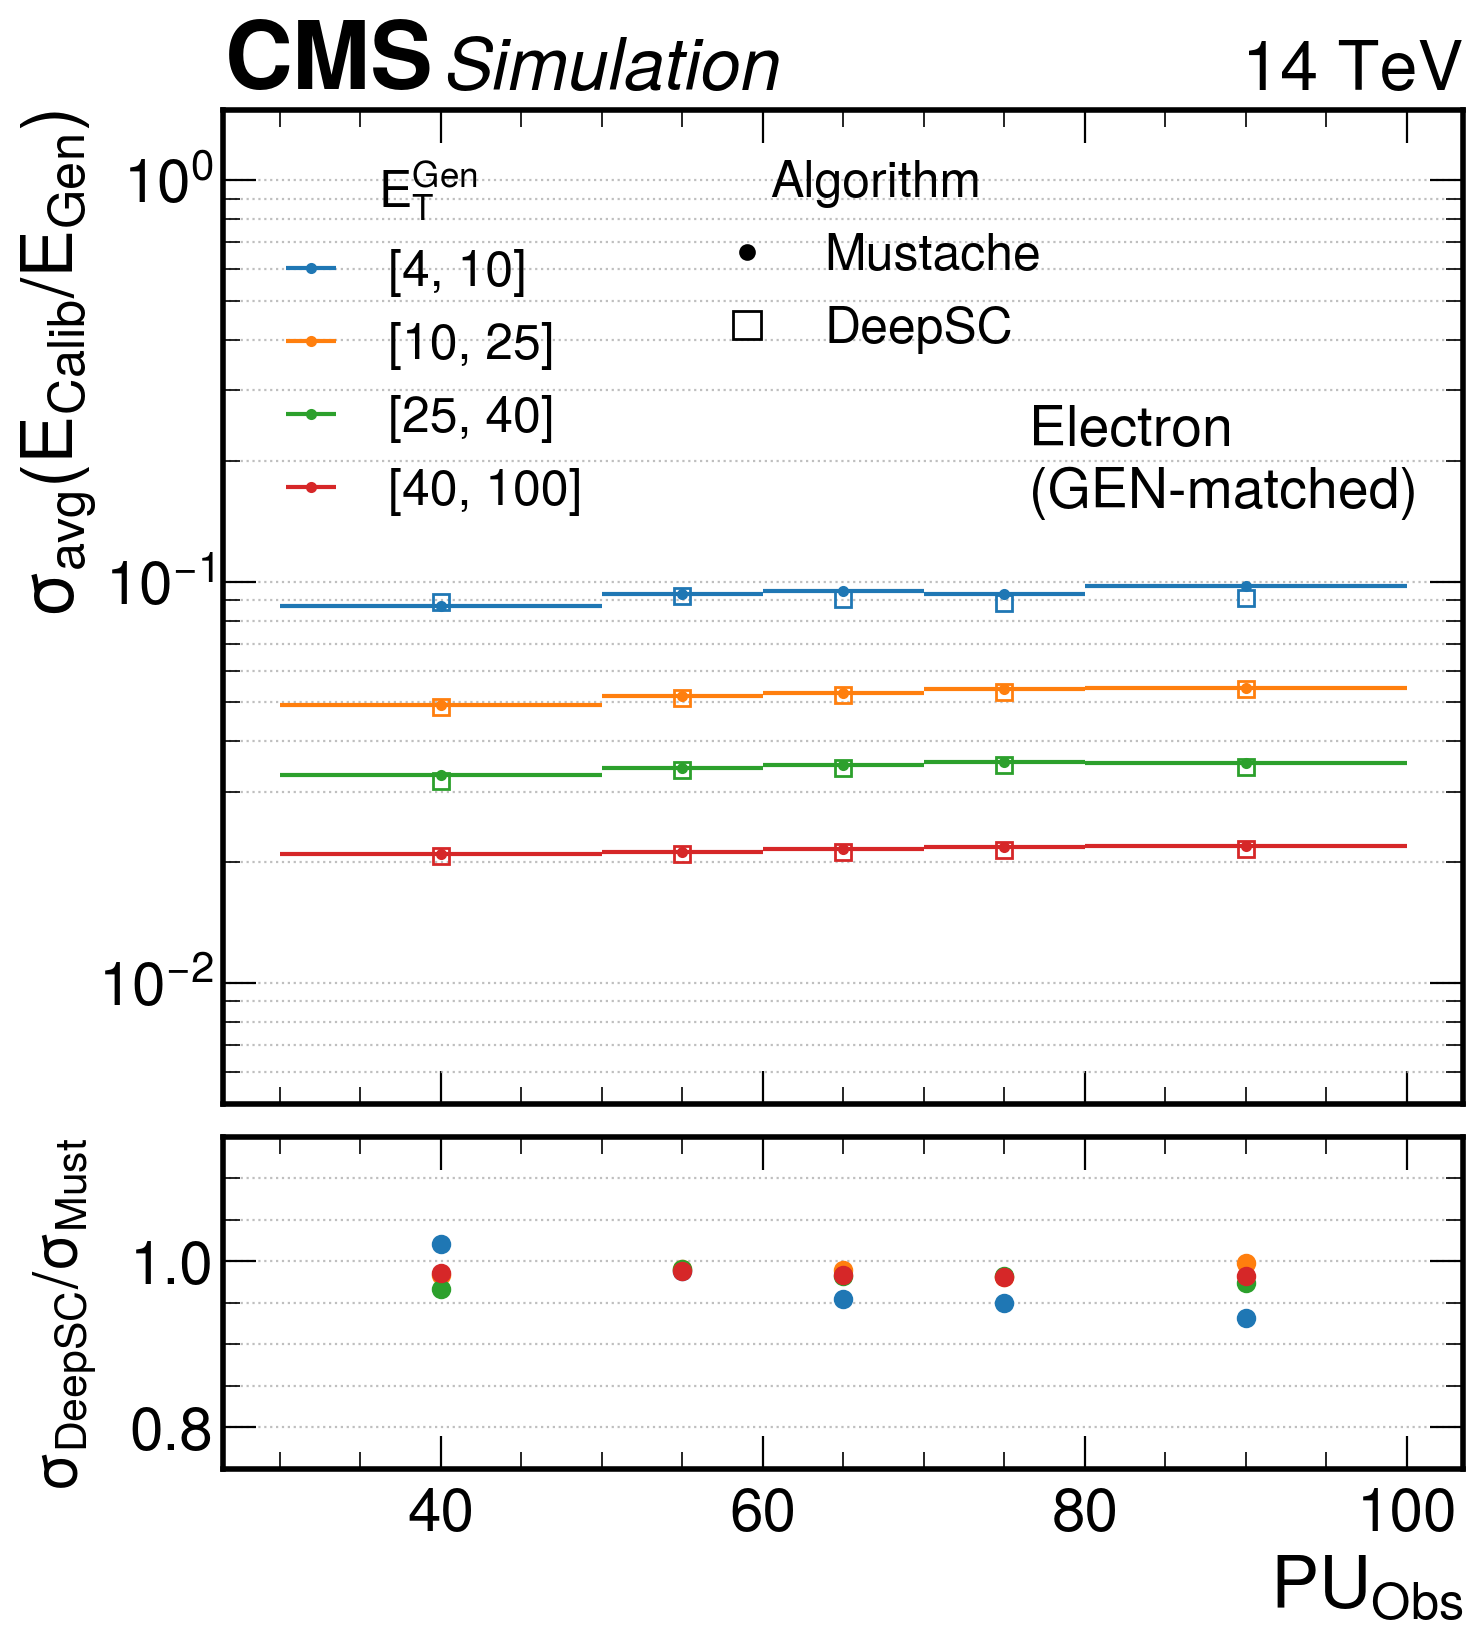

In [78]:
res_d, res_m = do_plot(name="ele_gen_matched_corr_byPU_et_cruiffavg",
        df=df_join, 
        res_var="Ecorr_ov_EGen", 
        bins2=[4, 10, 25, 40, 100],
        bins1=[30,50,60,70,80,100], 
        binlabel1="pu", 
        binlabel2="et", 
        binleg= "$E_T^{Gen}$",
        binvar1="obsPU_new", 
        binvar2="calo_et_gen_new", 
        general_label="Electron \n(GEN-matched)", 
        xlabel="$PU_{Obs}$", 
        ylabel="$\sigma_{avg}(E_{Calib}/E_{Gen})$",
        ylabelratio="$\sigma_{DeepSC}/\sigma_{Must}$", 
        yvar="sigma_avg",
        bin_analysis="fit",      
        ylims1=(5e-3,1.5),
        ylims2=(0.75, 1.15),
        output_folder=output_folder)

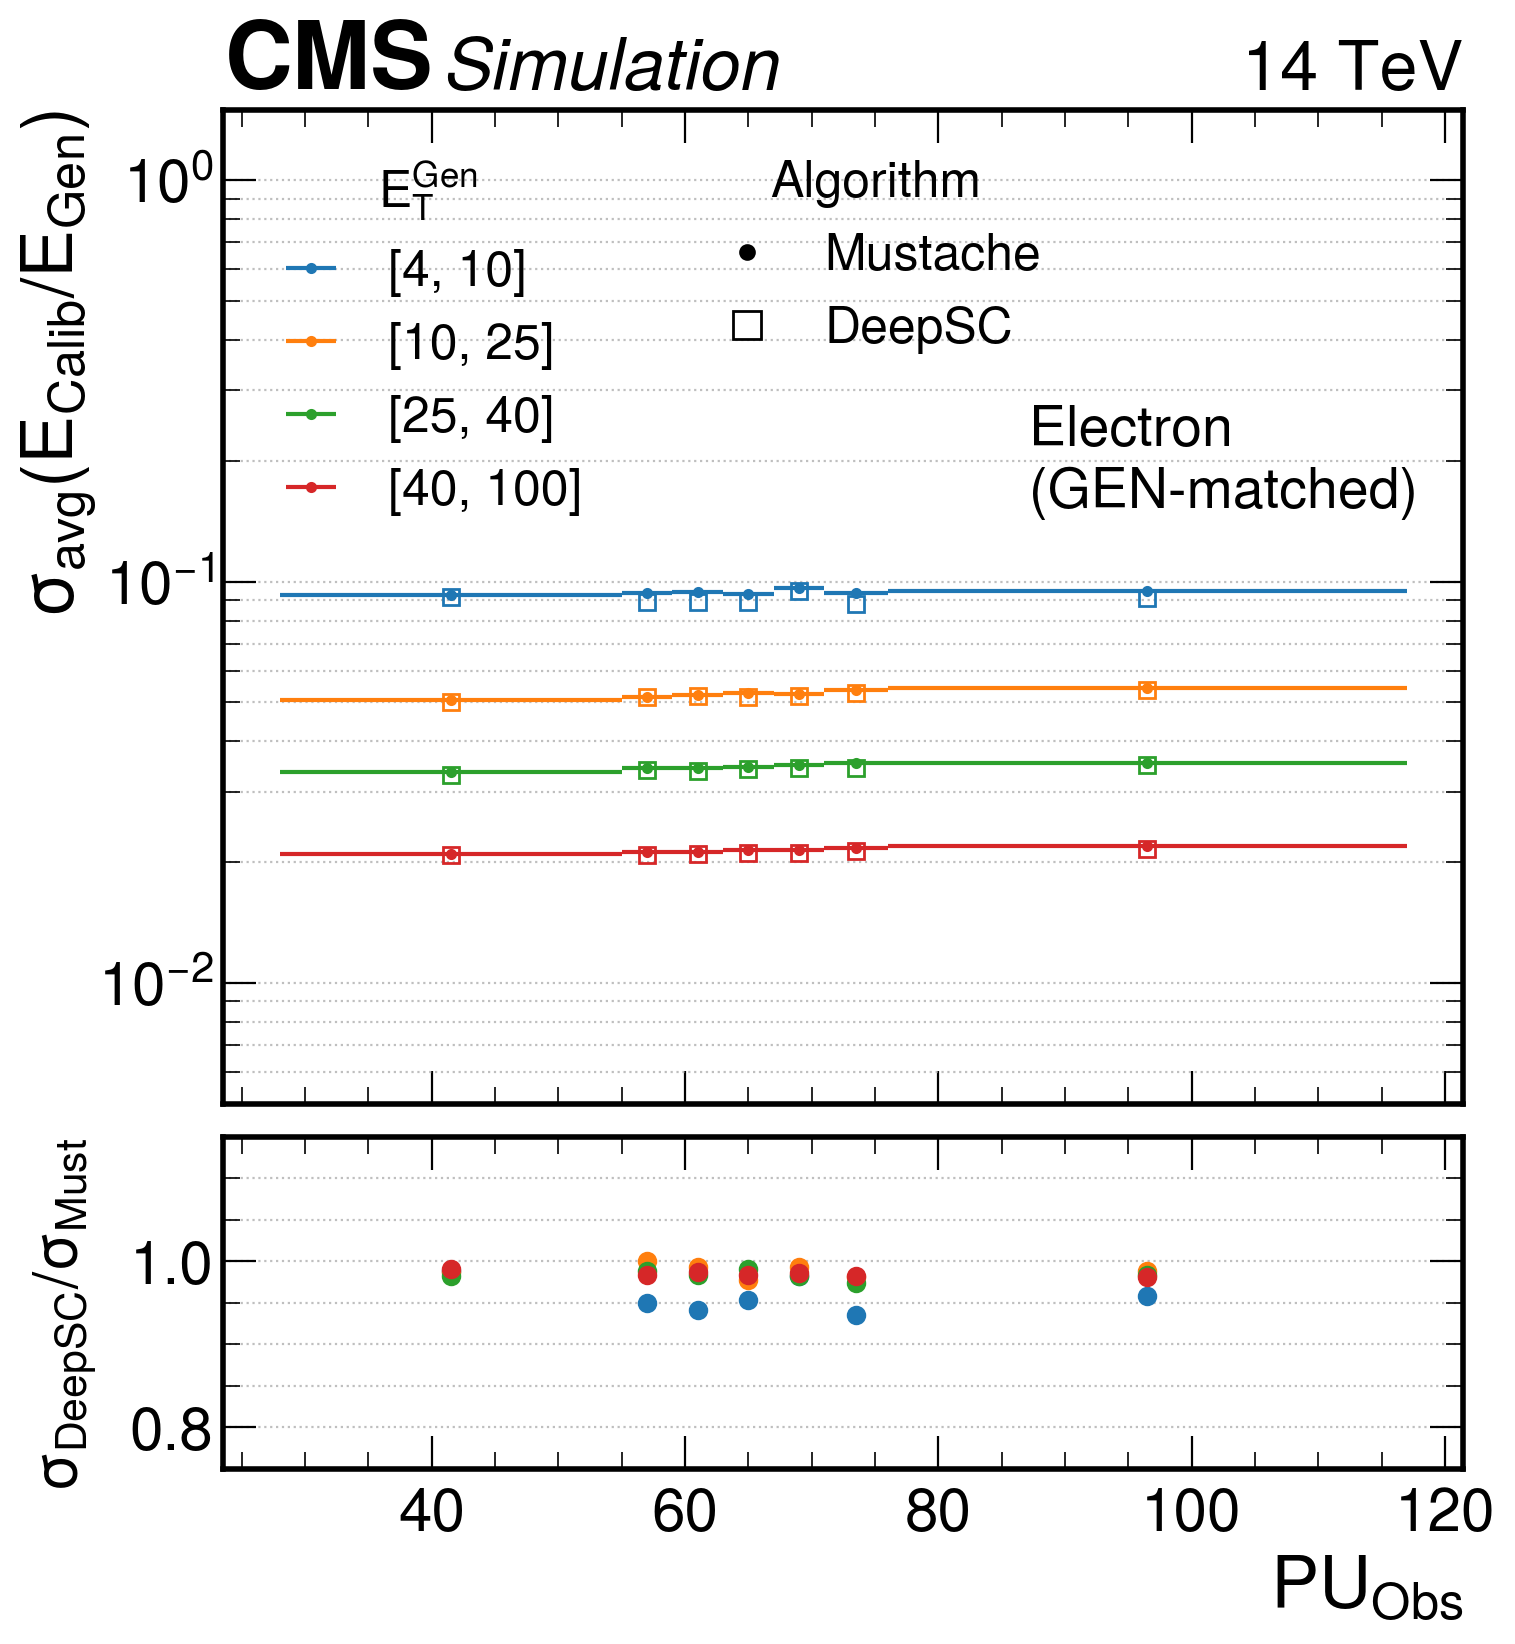

In [90]:
res_d, res_m = do_plot(name="ele_gen_matched_corr_byPU_et_cruiff_sigmaR",
        df=df_join, 
        res_var="Ecorr_ov_EGen", 
        bins1=[df_join.obsPU_new.quantile(q) for q in np.linspace(0,1,8)], 
        bins2=[4, 10, 25, 40, 100],
        binlabel1="pu", 
        binlabel2="et", 
        binleg= "$E_T^{Gen}$",
        binvar1="obsPU_new", 
        binvar2="calo_et_gen_new", 
        general_label="Electron \n(GEN-matched)", 
        xlabel="$PU_{Obs}$", 
        ylabel="$\sigma_{avg}(E_{Calib}/E_{Gen})$",
        ylabelratio="$\sigma_{DeepSC}/\sigma_{Must}$", 
        yvar="sigma_avg",
        bin_analysis="fit",      
        ylims1=(5e-3,1.5),
        ylims2=(0.75, 1.15),
        output_folder=output_folder)

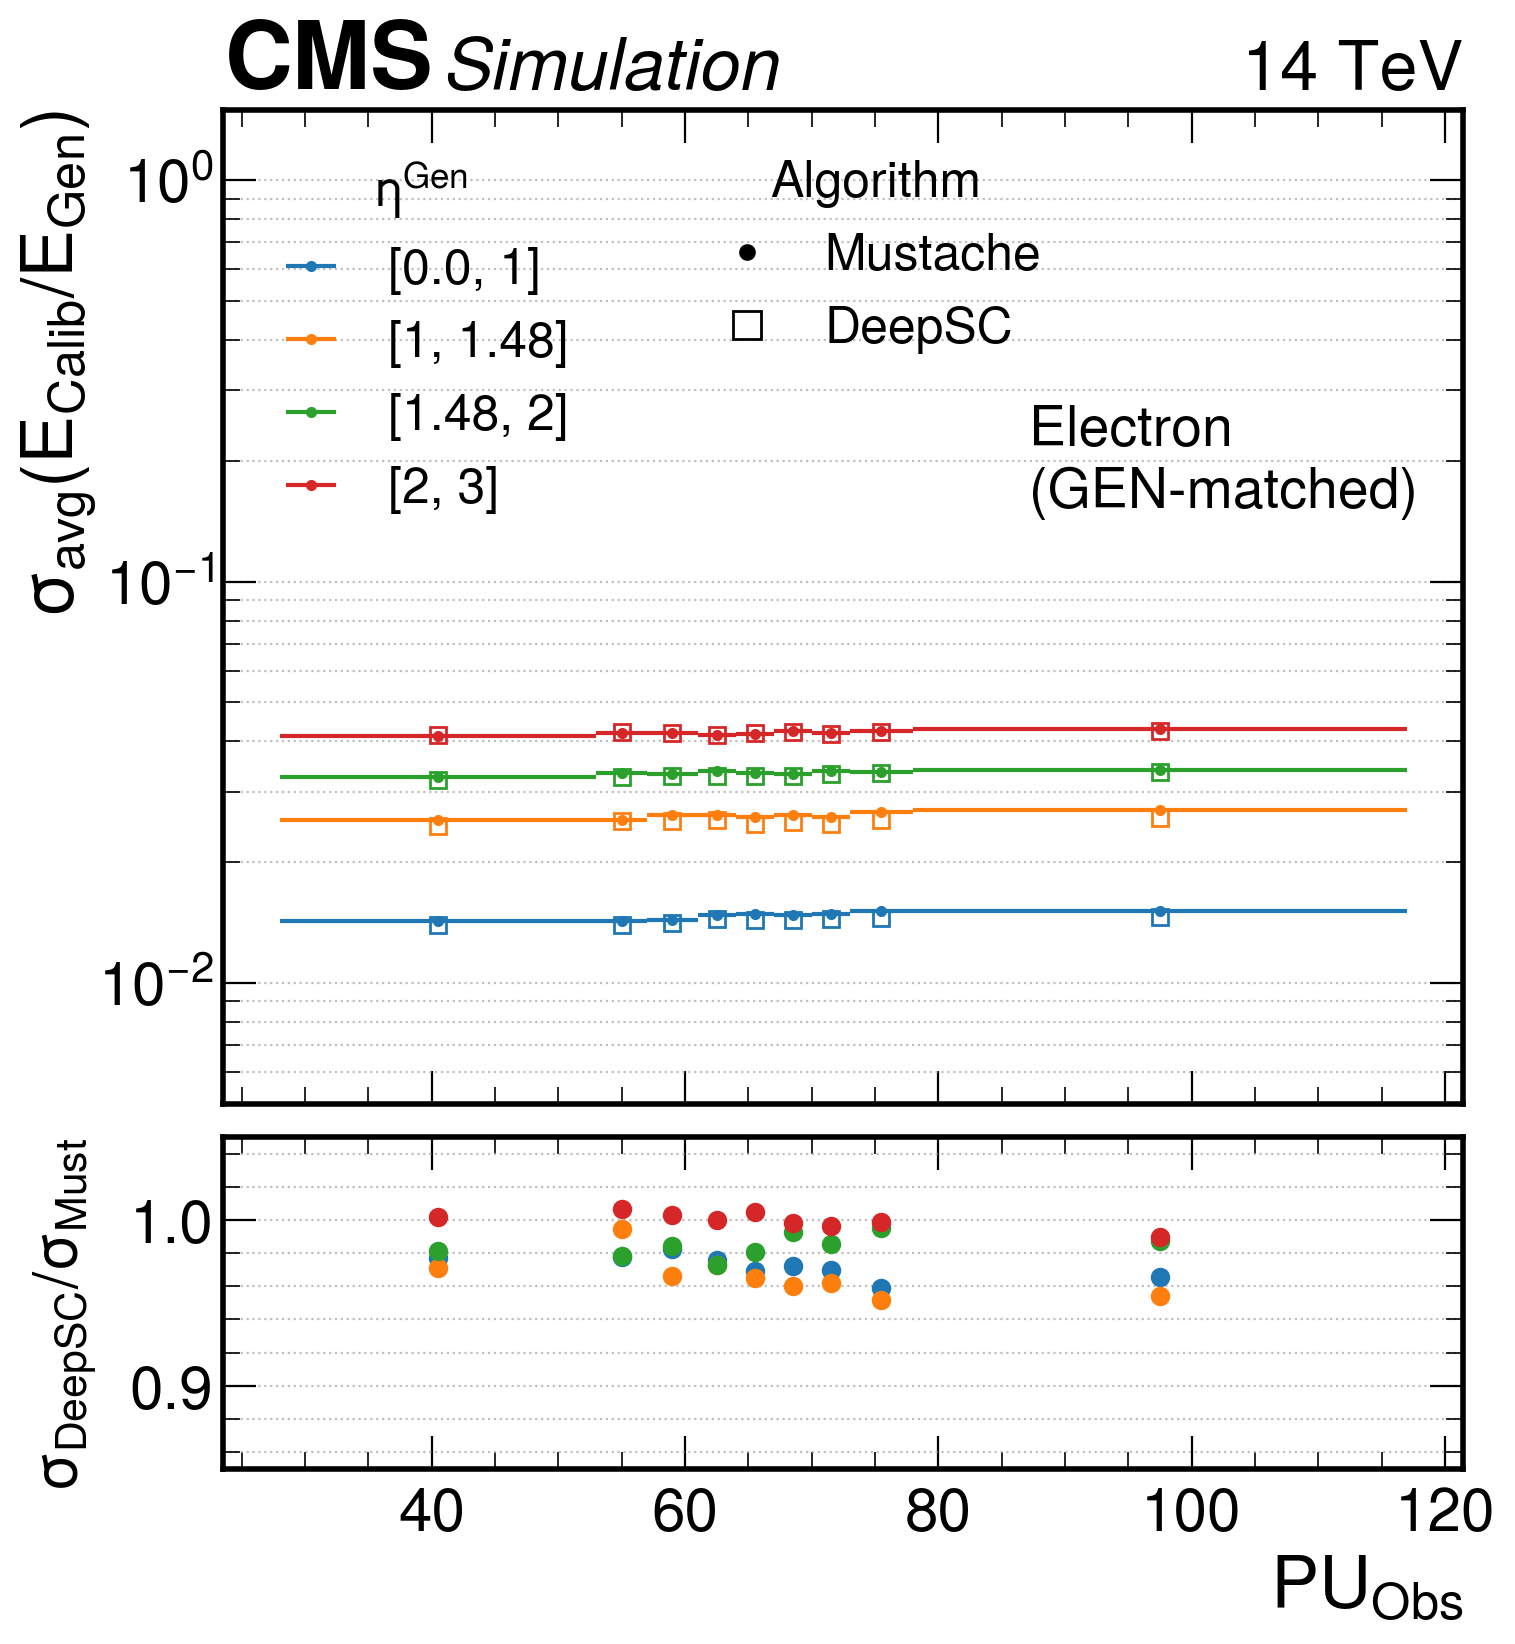

In [96]:
res_d, res_m = do_plot(name="ele_gen_matched_corr_byPU_et_cruiff_sigmaR",
        df=df_join, 
        res_var="Ecorr_ov_EGen", 
        bins1=[df_join.obsPU_new.quantile(q) for q in np.linspace(0,1,10)], 
        bins2=[0.,1,1.48, 2, 3],
        binlabel1="pu", 
        binlabel2="eta", 
        binleg= "$\eta^{Gen}$",
        binvar1="obsPU_new", 
        binvar2="seed_eta_new", 
        general_label="Electron \n(GEN-matched)", 
        xlabel="$PU_{Obs}$", 
        ylabel="$\sigma_{avg}(E_{Calib}/E_{Gen})$",
        ylabelratio="$\sigma_{DeepSC}/\sigma_{Must}$", 
        yvar="sigma_avg",
        bin_analysis="fit",      
        ylims1=(5e-3,1.5),
        ylims2=(0.85, 1.05),
        output_folder=output_folder)

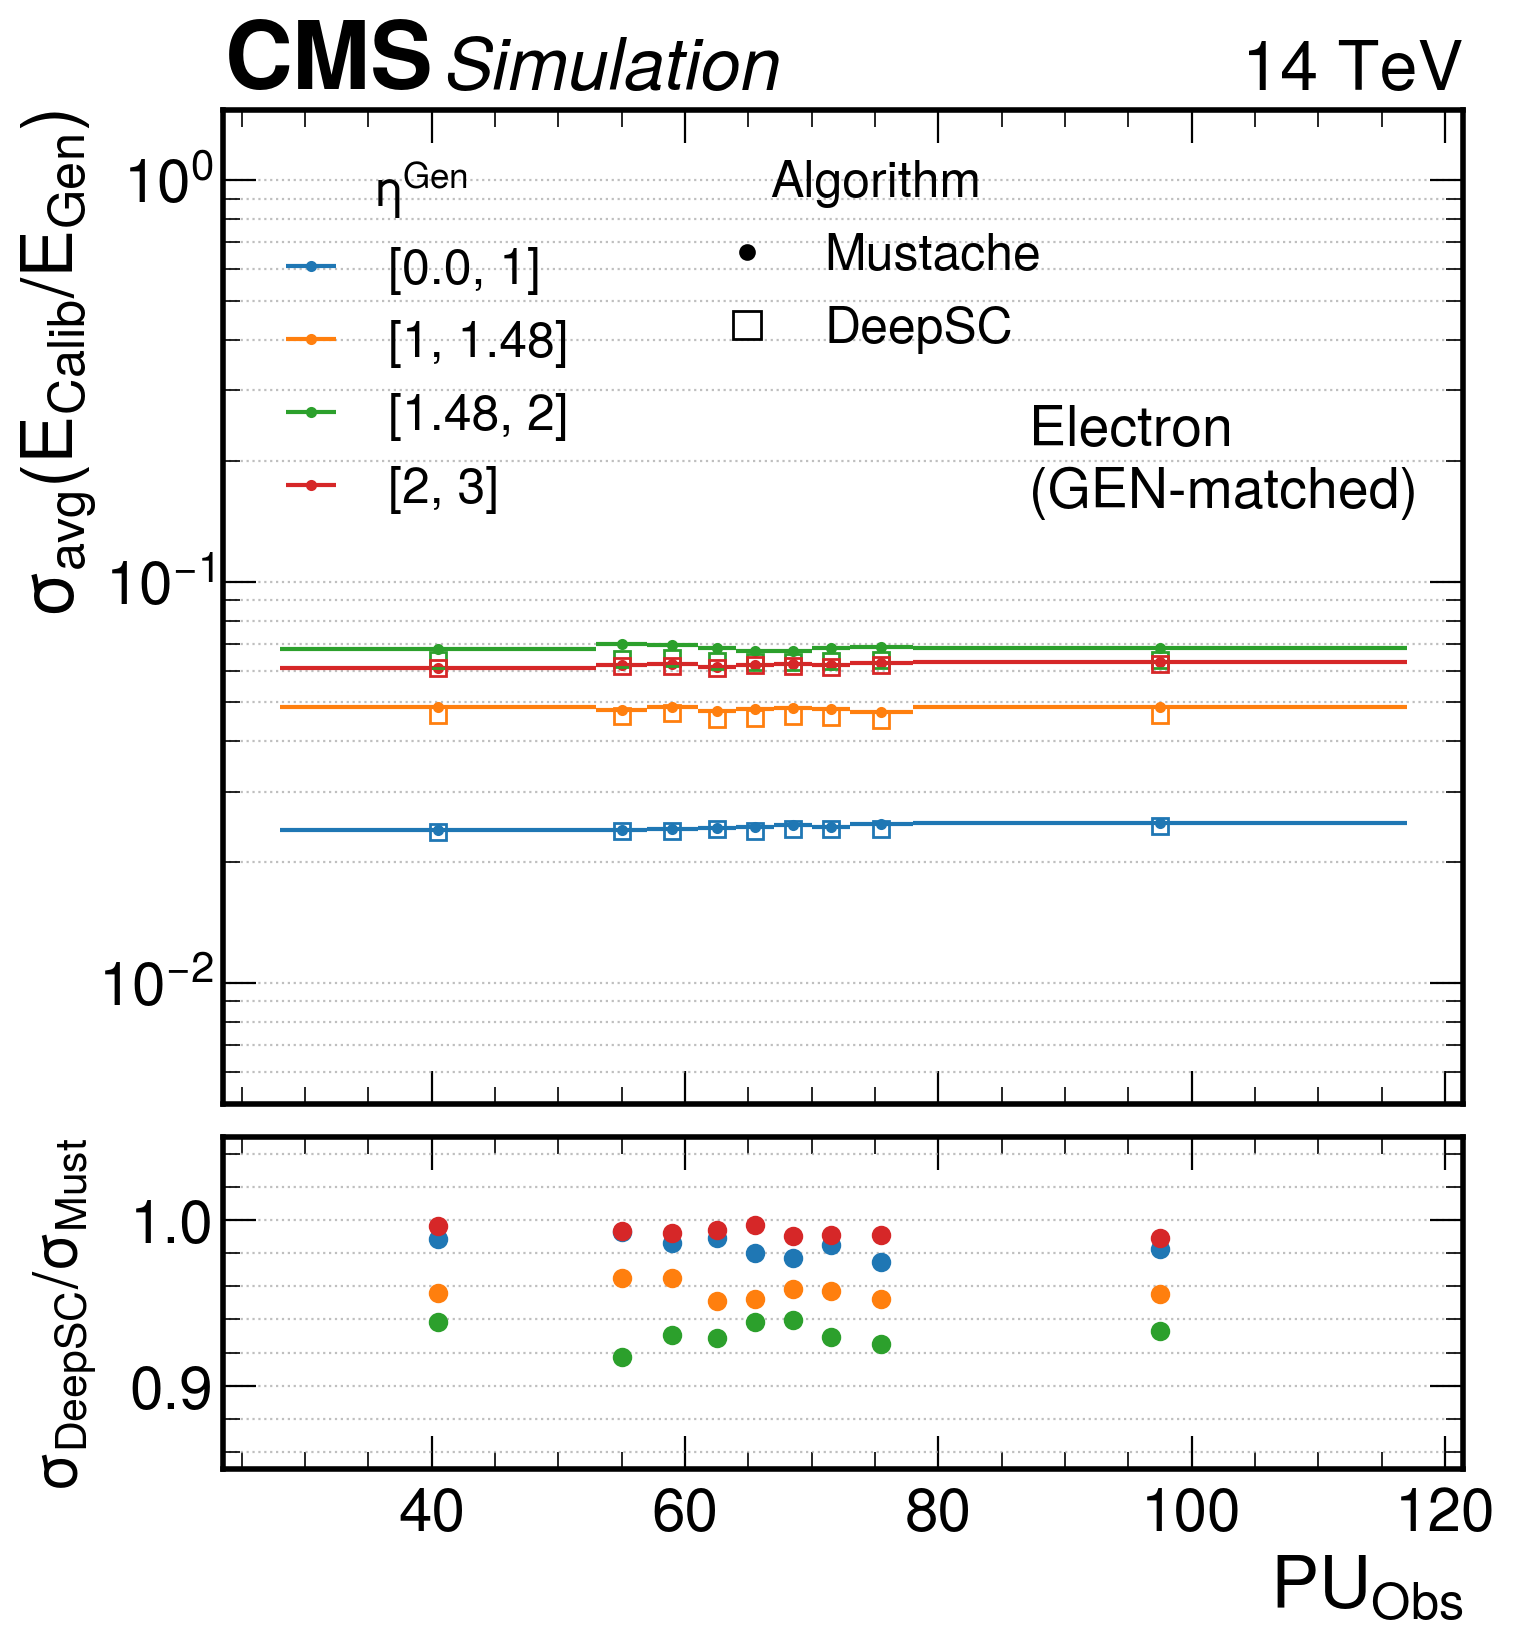

In [97]:
res_d, res_m = do_plot(name="ele_gen_matched_corr_byPU_et_extquantile",
        df=df_join, 
        res_var="Ecorr_ov_EGen", 
        bins1=[df_join.obsPU_new.quantile(q) for q in np.linspace(0,1,10)], 
        bins2=[0.,1,1.48, 2, 3],
        binlabel1="pu", 
        binlabel2="eta", 
        binleg= "$\eta^{Gen}$",
        binvar1="obsPU_new", 
        binvar2="seed_eta_new", 
        general_label="Electron \n(GEN-matched)", 
        xlabel="$PU_{Obs}$", 
        ylabel="$\sigma_{avg}(E_{Calib}/E_{Gen})$",
        ylabelratio="$\sigma_{DeepSC}/\sigma_{Must}$", 
        yvar="w68",
        bin_analysis="ext_quantile",      
        ylims1=(5e-3,1.5),
        ylims2=(0.85, 1.05),
        output_folder=output_folder)